In [1]:
import sys
sys.path.append("..")
%cd ..

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from scipy.stats import norm
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from DataPrep.ImportData import importer
from Tobit import Tobit

In [3]:
df = importer().Import()

In [4]:
testdata = df[df.Label == 0.0]


In [5]:
testdata = testdata.drop(columns=["Charging Time (mins)","Total Duration (mins)"])

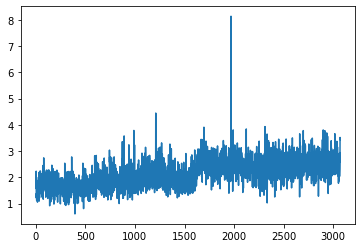

In [6]:
plt.plot(testdata["Energy (kWh)"])

In [7]:
def censor(s):
    energy = s["Energy (kWh)"] 
    energy_lag1 = s["Energy (kWh)_lag1"]
    energy_lag2 = s["Energy (kWh)_lag2"]
    energy_lag3 = s["Energy (kWh)_lag3"]
    energy_lag4 = s["Energy (kWh)_lag4"]
    energy_lag5 = s["Energy (kWh)_lag5"]

    s["Censored"] = False
    if energy > 3:
        s["Energy (kWh)"] = 3
        s["Censored"] = True
    if energy_lag1 > 3:
        s["Energy (kWh)_lag1"] = 3
    if energy_lag2 > 3:
        s["Energy (kWh)_lag2"] = 3
    if energy_lag3 > 3:
        s["Energy (kWh)_lag3"] = 3
    if energy_lag4 > 3:
        s["Energy (kWh)_lag4"] = 3
    if energy_lag5 > 3:
        s["Energy (kWh)_lag5"] = 3
    
    return s

In [8]:
testdata = testdata.apply(censor, axis=1)

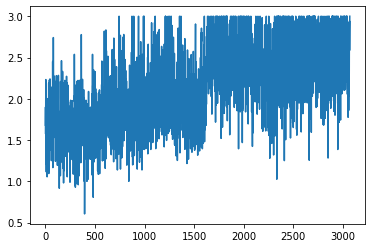

In [9]:
plt.plot(testdata["Energy (kWh)"])

In [10]:
testdata[testdata["Censored"] == False].shape

(2927, 84)

In [11]:
testdata["Energy (kWh)"]

0       1.679882
1       1.899242
2       1.574471
3       1.982032
4       2.232860
          ...   
3066    2.830458
3067    2.942766
3068    2.586043
3069    3.000000
3070    3.000000
Name: Energy (kWh), Length: 3071, dtype: float64

In [12]:
t = Tobit(testdata, 'Censored', ["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"], 'Energy (kWh)')

In [13]:
sd = np.linspace(0.0001,1, 40)
nlls = []
for i in sd:
    nlls.append(t.nll(i,3))


IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(sd,nlls)
plt.show()

In [18]:
regressor = LinearRegression().fit(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]), testdata["Energy (kWh)"])
pred = regressor.predict(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]))

In [ ]:
regressor = LinearRegression().fit(np.array(testdata[["Energy (kWh)_lag1"]]), testdata["Energy (kWh)"])
pred = regressor.predict(np.array(testdata[["Energy (kWh)_lag1"]]))

In [20]:
vars = [regressor.coef_,0.3]

In [21]:
minimizer = t.minimize(vars,3)

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021/env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

In [ ]:
minimizer["x"]

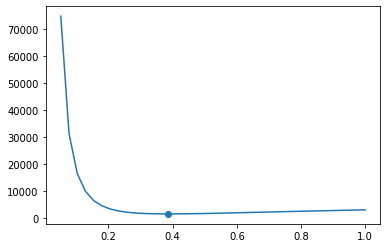

In [30]:
plt.plot(sd,nlls)
plt.scatter(minimizer["x"], t.nll(minimizer["x"],3))
plt.show()

In [31]:
sd = minimizer["x"]

In [32]:
regressor = LinearRegression().fit(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]), testdata["Energy (kWh)"])
pred = regressor.predict(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]))

In [33]:
regressor.coef_

array([0.18107919, 0.16463001, 0.16186996, 0.17187732, 0.13269433])

In [21]:
testdata["Energy (kWh)_lag1"].max()

3.0

In [39]:
pred_tobit = t.predict(np.log(sd), pred)

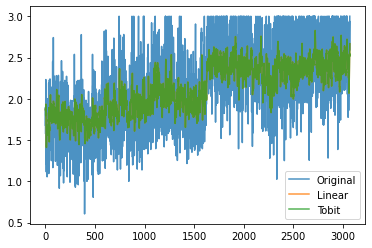

In [40]:
plt.plot(testdata["Energy (kWh)"], label = "Original", alpha = 0.8)
plt.plot(pred, label = "Linear", alpha = 0.8)
plt.plot(pred_tobit, label = "Tobit", alpha = 0.8)
plt.legend()
plt.show()

In [41]:
r2_score(testdata["Energy (kWh)"], pred_tobit)

0.3818656920190926

In [42]:
r2_score(testdata["Energy (kWh)"], pred)

0.38186564510234366

In [86]:
def nll(sd):
    y_not_censored = testdata["Energy (kWh)"][testdata["Censored"] == False]
    y_pred_not_censored = t.linear_regression(False)

    ll_not_censored = tf.math.reduce_sum(np.log(1/sd * norm.pdf((y_not_censored - y_pred_not_censored)/sd)))

    y_censored = testdata["Energy (kWh)"][testdata["Censored"] == True]
    y_pred_censored = t.linear_regression(True)
    ll_censored = tf.math.reduce_sum(np.log(norm.cdf((y_censored - y_pred_censored)/sd)))

    return float(- ll_not_censored - ll_censored)

In [113]:
y_censored = testdata["Energy (kWh)"][testdata["Censored"] == True]
y_pred_censored = t.linear_regression(True)
tf.math.reduce_sum(np.log(norm.cdf((y_censored - y_pred_censored)/2)))

<tf.Tensor: shape=(), dtype=float64, numpy=-63.38043014430555>

In [119]:
sum(np.log(norm.cdf((y_censored - y_pred_censored)/0.06)))

-0.004717613610609299

In [24]:
import tensorflow_probability as tfp

In [36]:
def tobit_type1_nll_tensorflow(y_true, y_pred, noise_sigma, upper_threshold):
    def get_cens_labels(y_true):
        return y_true >= upper_threshold
    
    def nll_not_censored(y_true, y_pred, noise_sigma):
        return -tf.math.reduce_sum(
            np.log(1 / noise_sigma) + \
            tfp.distributions.Normal(loc=0, scale=1).log_prob(
                (tf.boolean_mask(y_true, ~get_cens_labels(y_true)) - \
                 tf.boolean_mask(y_pred, ~get_cens_labels(y_true)) \
                ) / noise_sigma))
    
    def nll_censored(y_true, y_pred, noise_sigma, upper_threshold):
        return -tf.math.reduce_sum(
            tfp.distributions.Normal(loc=0, scale=1)\
                .log_cdf((tf.boolean_mask(y_pred, get_cens_labels(y_true)) - upper_threshold) \
                         / noise_sigma))
    
    
    

    return \
        nll_not_censored(y_pred=y_pred, 
                         y_true=y_true, 
                         noise_sigma=noise_sigma) + \
        nll_censored(y_true=y_true,
                     y_pred=y_pred,
                     noise_sigma=noise_sigma,
                     upper_threshold=upper_threshold)

In [37]:
tobit_type1_nll_tensorflow(testdata["Energy (kWh)"].astype('float32'), pred.astype('float32'), sd, 3)

<tf.Tensor: shape=(), dtype=float32, numpy=1920.4941>

In [41]:
minimize(tobit_type1_nll_tensorflow, 0.01,method="BFGS", args=(testdata["Energy (kWh)"].astype('float32'),pred.astype('float32'),3))

ValueError: Shapes (3071,) and (1,) are incompatible